In [1]:
from rajvi_mapbox_api import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium

In [2]:
branchRadii = gpd.read_file('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')
api = MapboxAPI() 

In [3]:
# prepping base branchRadii dataframe
branchRadii[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchRadii['LOCATION']]
branchRadii.loc[:, 'LATITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LATITUDE'])
branchRadii.loc[:, 'LONGITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LONGITUDE'])
branchRadii.head()

branchRadii = branchRadii[(branchRadii['BRANCH'] != 'Roosevelt')]
branchRadii = branchRadii.drop(['HOURS OF OPERATION', 'ADDRESS', 
                                'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE', 'PERMANENTLY_CLOSED'], axis=1)
branchRadii = branchRadii.reset_index(drop=True)

branchRadii = branchRadii.set_crs('epsg:4326')

In [4]:
# creating and prepping other data frames to be mapped -- these will not be modified later

# census map prep
censusTracts = populationDemographics[['geoid','geometry','qualifying name', 'current land area (sq. m)', 'current water area (sq. m)', ]]
branchLocsOnly=branchRadii[['BRANCH','LOCATION']]

censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

# branch locations map prep
branchLocsOnly.crs = 'EPSG:4326'
branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
branchLocsOnly = branchLocsOnly.drop(columns='LOCATION')

branchLocsOnly = gpd.GeoDataFrame(
    branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:4326")

/tmp/ipykernel_2179245/2420311521.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/tmp/ipykernel_2179245/2420311521.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]


In [5]:
def generateRadii (time):
    newRadius = branchRadii.copy(deep = True)
    newRadius = newRadius.set_crs('epsg:4326')
    for i in range(newRadius.shape[0]):
        api_response =  api.get_data((newRadius.loc[i,'LATITUDE'],newRadius.loc[i,'LONGITUDE']), time)
        newRadius.loc[i,'geometry'] = shape(api_response)
    return newRadius

In [9]:
branchRadii1 = generateRadii(1)

branchRadii3 = generateRadii(3)
branchRadii3Mod = branchRadii3.copy(deep = True)

branchRadii5 = generateRadii(5)
branchRadii5Mod = branchRadii5.copy(deep = True)

branchRadii7 = generateRadii(7)
branchRadii7Mod = branchRadii7.copy(deep = True)

branchRadii9 = generateRadii(9)
branchRadii9Mod = branchRadii9.copy(deep = True)

In [10]:
branchRadii11 = generateRadii(11)
branchRadii11Mod = branchRadii11.copy(deep = True)

branchRadii13 = generateRadii(13)
branchRadii13Mod = branchRadii13.copy(deep = True)

branchRadii15 = generateRadii(15)
branchRadii15Mod = branchRadii15.copy(deep = True)

branchRadii17 = generateRadii(17)
branchRadii17Mod = branchRadii17.copy(deep = True)

In [18]:
branchRadii19 = generateRadii(19)
branchRadii19Mod = branchRadii19.copy(deep = True)

branchRadii21 = generateRadii(21)
branchRadii21Mod = branchRadii21.copy(deep = True)

branchRadii23 = generateRadii(23)
branchRadii23Mod = branchRadii23.copy(deep = True)

branchRadii25 = generateRadii(25)
branchRadii25Mod = branchRadii25.copy(deep = True)

In [28]:
branchRadii27 = generateRadii(27)
branchRadii27Mod = branchRadii27.copy(deep = True)

branchRadii30 = generateRadii(30)
branchRadii30Mod = branchRadii30.copy(deep = True)

In [11]:
def removeOverlapWithinLayer (largeTimeFrame, smallerTimeFrame):
    #outerRadiusNoOverlap = gpd.GeoDataFrame(columns=['BRANCH','geometry'], geometry='geometry', crs='EPSG:4326')
    for i in range(largeTimeFrame.shape[0]):    
        oneLargeRadius = gpd.GeoDataFrame({'BRANCH': [largeTimeFrame.loc[i,'BRANCH']],'geometry': [largeTimeFrame.loc[i,'geometry']]})
        #oneLargeRadius = oneLargeRadius.set_crs(crs='EPSG:4326')
        #oneLargeRadius = oneLargeRadius.to_crs('espg=4326')
        
        for j in range(largeTimeFrame.shape[0]):
            rotatingSmallRadius = gpd.GeoDataFrame({'BRANCH': [smallerTimeFrame.loc[j,'BRANCH']],'geometry': [smallerTimeFrame.loc[j,'geometry']]})
            outerOnly = oneLargeRadius.difference(rotatingSmallRadius)
            oneLargeRadius['geometry'] = outerOnly[0]
            
            if (i != j):
                rotatingLargeRadius = gpd.GeoDataFrame({'BRANCH': [largeTimeFrame.loc[j,'BRANCH']],'geometry': [largeTimeFrame.loc[j,'geometry']]})
                largerNoOverlap = oneLargeRadius.difference(rotatingLargeRadius)
                oneLargeRadius['geometry'] = largerNoOverlap[0]
                
        #outerRadiusNoOverlap = pd.concat([outerRadiusNoOverlap, oneLargeRadius])
        largeTimeFrame.loc[i, 'geometry'] = oneLargeRadius['geometry'][0]
    
    return largeTimeFrame

In [12]:
branchRadii3minus1 = removeOverlapWithinLayer(branchRadii3Mod, branchRadii1)
branchRadii5minus3 = removeOverlapWithinLayer(branchRadii5Mod, branchRadii3)
branchRadii7minus5 = removeOverlapWithinLayer(branchRadii7Mod, branchRadii5)
branchRadii9minus7 = removeOverlapWithinLayer(branchRadii9Mod, branchRadii7)
branchRadii11minus9 = removeOverlapWithinLayer(branchRadii11Mod, branchRadii9)
branchRadii13minus11 = removeOverlapWithinLayer(branchRadii13Mod, branchRadii11)
branchRadii15minus13 = removeOverlapWithinLayer(branchRadii15Mod, branchRadii13)
branchRadii17minus15 = removeOverlapWithinLayer(branchRadii17Mod, branchRadii15)

In [19]:
branchRadii17minus15 = removeOverlapWithinLayer(branchRadii17Mod, branchRadii15)
branchRadii19minus17 = removeOverlapWithinLayer(branchRadii19Mod, branchRadii17)
branchRadii21minus19 = removeOverlapWithinLayer(branchRadii21Mod, branchRadii19)
branchRadii23minus21 = removeOverlapWithinLayer(branchRadii23Mod, branchRadii21)
branchRadii25minus23 = removeOverlapWithinLayer(branchRadii25Mod, branchRadii23)


In [29]:
branchRadii27minus25 = removeOverlapWithinLayer(branchRadii27Mod, branchRadii25)
branchRadii30minus27 = removeOverlapWithinLayer(branchRadii30Mod, branchRadii27)

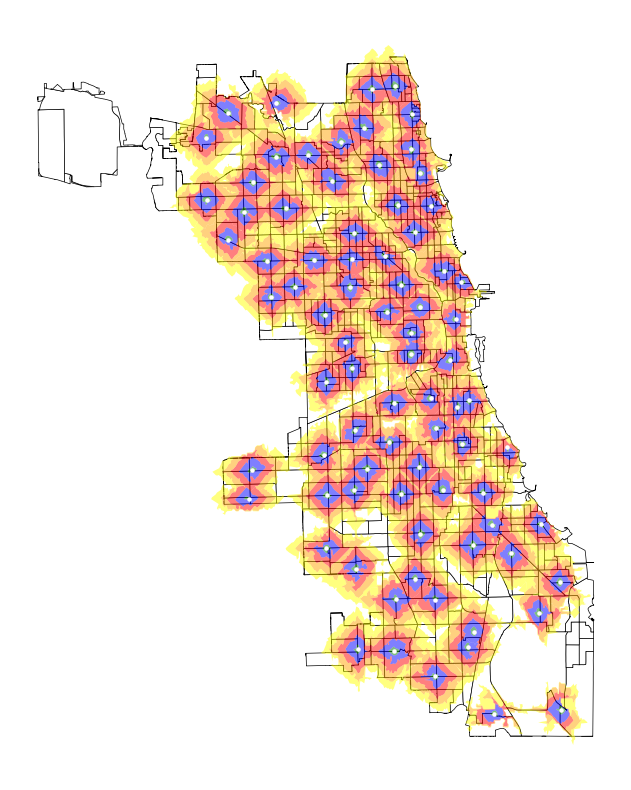

In [36]:
# plots all overlapping maps (census, lib locations, and each radius)

fig, ax = plt.subplots(1, figsize=(10, 10))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black', linewidth = .5)
ax.axis('off')

branchRadii1.plot(ax=base, alpha = .5, color = 'green')
branchRadii3minus1.plot(ax=base, alpha = .5, color = 'blue')
branchRadii5minus3.plot(ax=base, alpha = .5, color = 'red')
branchRadii7minus5.plot(ax=base, alpha = .5, color = 'orange')
branchRadii9minus7.plot(ax=base, alpha = .5, color = 'yellow')
#branchRadii11minus9.plot(ax=base, alpha = .5, color = 'green')
#branchRadii13minus11.plot(ax=base, alpha = .5, color = 'blue')
#branchRadii15minus13.plot(ax=base, alpha = .5, color = 'red')
#branchRadii17minus15.plot(ax=base, alpha = .5, color = 'orange')

#branchRadii19minus17.plot(ax=base, alpha = .5, color = 'yellow')
#branchRadii21minus19.plot(ax=base, alpha = .5, color = 'green')
#branchRadii23minus21.plot(ax=base, alpha = .5, color = 'blue')
#branchRadii25minus23.plot(ax=base, alpha = .5, color = 'red')
#branchRadii27minus25.plot(ax=base, alpha = .5, color = 'orange')
#branchRadii30minus27.plot(ax=base, alpha = .5, color = 'yellow')


branchLocsOnly.plot(ax=base, marker='o', color='white', markersize=5);


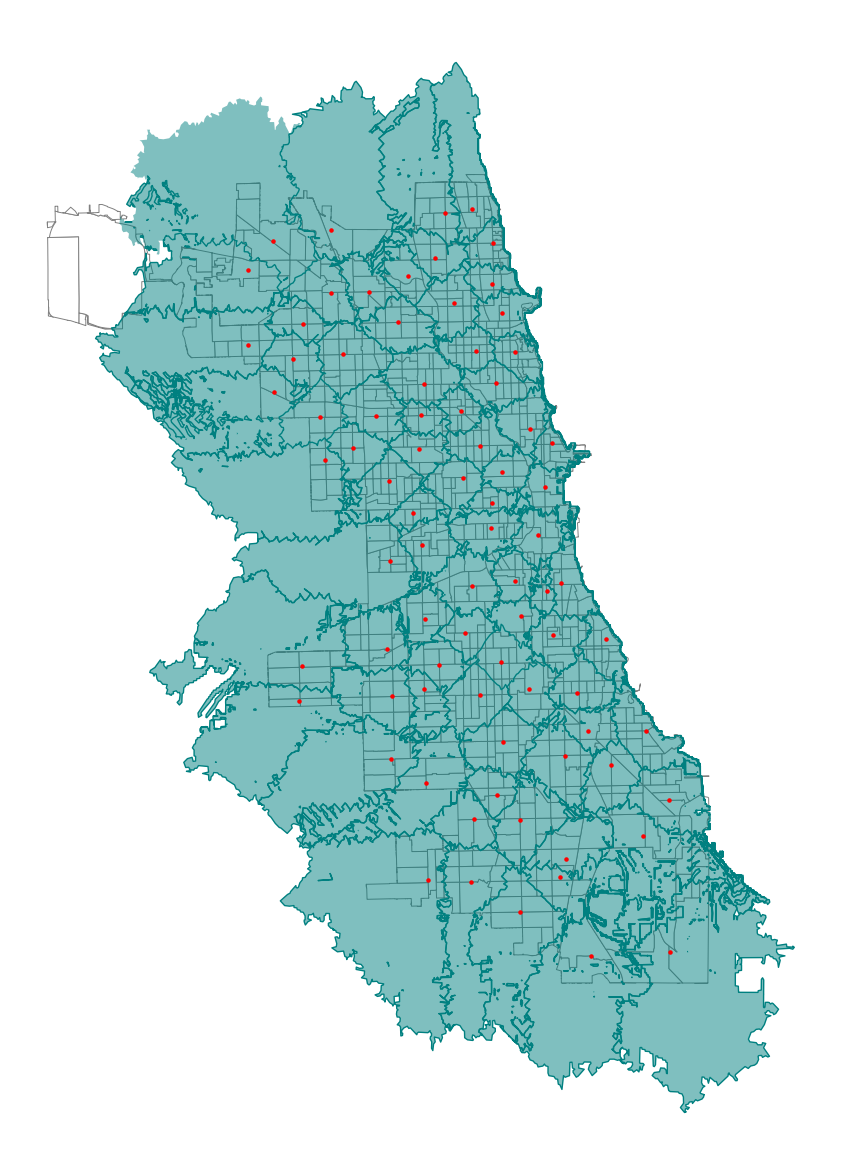

In [31]:
neighborhoodRadii = branchRadii1.copy(deep=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii3minus1, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii5minus3, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii7minus5, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii9minus7, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii11minus9, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii13minus11, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii15minus13, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii17minus15, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii19minus17, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii21minus19, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii23minus21, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii25minus23, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii27minus25, align=True)
neighborhoodRadii = neighborhoodRadii.union(branchRadii30minus27, align=True)

fig, ax = plt.subplots(1, figsize=(15, 15))
base = censusTracts.plot(ax=ax, color='white', edgecolor='gray', linewidth=.7)
ax.axis('off')

neighborhoodRadii.boundary.plot(ax=base, alpha = 1, color = 'teal', linewidth = 1)
neighborhoodRadii.plot(ax=base, alpha = .5, color = 'teal', linewidth = 1)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);

In [32]:
completedNeighborhoodRadiiDF = branchRadii.copy(deep=True)
completedNeighborhoodRadiiDF['geometry'] = neighborhoodRadii[:]
completedNeighborhoodRadiiDF

,BRANCH,LOCATION,geometry,LATITUDE,LONGITUDE
0,Albany Park,"(41.97557881655979, -87.71361314512697)","MULTIPOLYGON (((-87.71110 41.98370, -87.71163 ...",41.975579,-87.713613
1,Altgeld,"(41.65719847558056, -87.59883829075173)","MULTIPOLYGON (((-87.57900 41.65743, -87.57782 ...",41.657198,-87.598838
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","MULTIPOLYGON (((-87.73394 41.78904, -87.73448 ...",41.801108,-87.726484
3,Austin,"(41.88917312206642, -87.7658203582574)","MULTIPOLYGON (((-87.75406 41.88514, -87.75206 ...",41.889173,-87.765820
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","MULTIPOLYGON (((-87.76657 41.95384, -87.76130 ...",41.953123,-87.779285
...,...,...,...,...,...
76,West Pullman,"(41.67790647382097, -87.6431683153105)","MULTIPOLYGON (((-87.61548 41.67931, -87.61417 ...",41.677906,-87.643168
77,West Town,"(41.89594730478282, -87.66829305460979)","MULTIPOLYGON (((-87.67131 41.90593, -87.67091 ...",41.895947,-87.668293
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","MULTIPOLYGON (((-87.60798 41.75899, -87.60760 ...",41.751018,-87.614951
79,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","MULTIPOLYGON (((-87.65605 41.72356, -87.65405 ...",41.720695,-87.643048


In [33]:
completedNeighborhoodRadiiDF
completedNeighborhoodRadiiDF.to_csv('../library neighborhoods/completedCyclingNeighborhoodRadiiDF.csv')

In [34]:
#branchRadii7
#branchRadii9minus7
#branchRadii11minus9
#branchRadii13minus11
#branchRadii15minus13
#branchRadii17minus15
#branchRadii19minus17
#branchRadii21minus19
#branchRadii23minus21
#branchRadii25minus23
#branchRadii27minus25
#branchRadii29minus27

# i need to get a dataframe with the census overlaps for each of these rounds
# so first i need a csv of each of these
branchRadii1.to_csv('../library neighborhoods/cyc1branchRadii.csv')
branchRadii3minus1.to_csv('../library neighborhoods/cyc3minus1branchRadii.csv')
branchRadii5minus3.to_csv('../library neighborhoods/cyc5minus3branchRadii.csv')
branchRadii7minus5.to_csv('../library neighborhoods/cyc7minus5branchRadii.csv')
branchRadii9minus7.to_csv('../library neighborhoods/cyc9minus7branchRadii.csv')
branchRadii11minus9.to_csv('../library neighborhoods/cyc11minus9branchRadii.csv')
branchRadii13minus11.to_csv('../library neighborhoods/cyc13minus11branchRadii.csv')
branchRadii15minus13.to_csv('../library neighborhoods/cyc15minus13branchRadii.csv')
branchRadii17minus15.to_csv('../library neighborhoods/cyc17minus15branchRadii.csv')
branchRadii19minus17.to_csv('../library neighborhoods/cyc19minus17branchRadii.csv')
branchRadii21minus19.to_csv('../library neighborhoods/cyc21minus19branchRadii.csv')
branchRadii23minus21.to_csv('../library neighborhoods/cyc23minus21branchRadii.csv')
branchRadii25minus23.to_csv('../library neighborhoods/cyc25minus23branchRadii.csv')
branchRadii27minus25.to_csv('../library neighborhoods/cyc27minus25branchRadii.csv')
branchRadii30minus27.to_csv('../library neighborhoods/cyc30minus27branchRadii.csv')
